In [0]:
# Under IAM in GCP, choose Service Accounts and Click on Create Service Account and save the Key File and upload it to Google Drive
# Search for BigQuery Storage API in GCP Search and Click on Enable API

In [0]:
# Install the google-cloud-bigquery-storage and fastavro packages to use the BigQuery Storage API
!pip install google-cloud-bigquery-storage

In [0]:
# Download large query results with the BigQuery Storage API by adding the --use_bq_storage_api argument to the %%bigquery magics.
# Alternately, set the context.use_bqstorage_api property to True to use the BigQuery Storage API by default.
# For the same, uncomment the below two lines
import google.cloud.bigquery.magics
google.cloud.bigquery.magics.context.use_bqstorage_api = True
# After you set the context.use_bqstorage_api property, run the %%bigquery magics without additional arguments to use the 
# BigQuery Storage API to download large results.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from google.cloud import storage
# Generate key using Service Accounts under IAM & admin of the Navigation Menu of Google Cloud Platform
credentials="/content/drive/My Drive/Colab Notebooks/affable-alpha-245006-4ecb4a78a187.json"

# Explicitly use service account credentials by specifying the private key file.
storage_client = storage.Client.from_service_account_json(credentials)

# Make an authenticated API request
buckets = list(storage_client.list_buckets())
print(buckets)

[]


In [0]:
# Use GOOGLE_APPLICATION_CREDENTIALS env variable to reference the service account key
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=credentials

In [0]:
%%bigquery
SELECT subreddit,count(*) cnt FROM `fh-bigquery.reddit_comments.2016_12` GROUP BY subreddit ORDER BY cnt DESC LIMIT 100

,subreddit,cnt
0,AskReddit,5121184
1,politics,1797923
2,The_Donald,1278374
3,nfl,1025385
4,RocketLeagueExchange,850527
5,worldnews,766271
6,nba,657998
7,funny,627594
8,news,620686
9,leagueoflegends,619382


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM, Conv1D, Input, MaxPooling1D, GlobalMaxPooling1D, Dropout, Activation

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import Constant

Using TensorFlow backend.


In [0]:
from google.cloud import bigquery

In [0]:
# Connect to BigQuery to run the query
bq_client=bigquery.Client()

In [0]:
%%bigquery
SELECT count(*)
FROM `fh-bigquery.reddit_comments.2016_12`
WHERE score>=0 and body not in ('[deleted]','[removed]')
AND subreddit='cars'

,f0_
0,479418


In [0]:
# Download query results.
query_string = """
SELECT *
FROM `fh-bigquery.reddit_comments.2016_12`
WHERE body not in ('[deleted]','[removed]')
AND subreddit='cars'
"""

In [0]:
query_job=bq_client.query(query_string) # API Request

In [0]:
# Call the to_dataframe method on the reader to write the entire stream to a pandas DataFrame
rows_df=query_job.result().to_dataframe() # Waits for query to finish


In [0]:
new_df=rows_df.copy(deep=True)

In [0]:
new_df.score.describe()

count    108069.000000
mean          6.298948
std          23.469071
min        -125.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        1358.000000
Name: score, dtype: float64

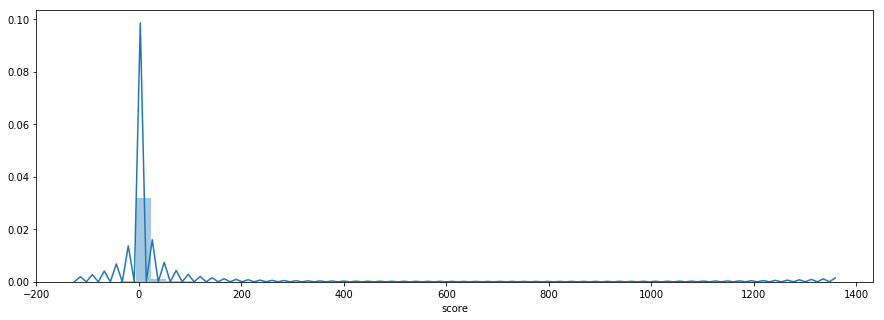

In [0]:
 # Below we'll plot some charts of the distribution and various normalization techniques
  plt.figure(figsize=(15,5))
  sns.distplot(new_df.score);

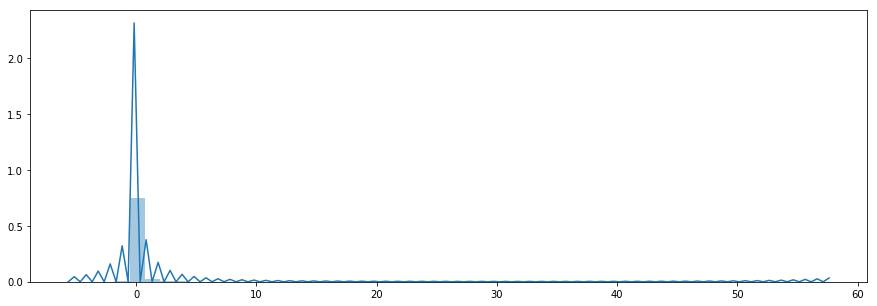

In [0]:
scaler=StandardScaler()
scores=scaler.fit_transform(new_df.score.values.reshape(-1,1))

plt.figure(figsize=(15,5))
sns.distplot(scores);

In [0]:
# After exploring the distribution it appears that it appears that regression is not a good option here
custom_buckets = [-100,0,1,10,50,1500]
labels=['Downvoted','No Votes','2-10 Votes','11-50 Votes','50+ Votes']

In [0]:
pd.cut(new_df.score, custom_buckets,labels=labels).value_counts()

2-10 Votes     48085
No Votes       41626
11-50 Votes    10373
Downvoted       5886
50+ Votes       2097
Name: score, dtype: int64

In [0]:
new_df['score_category']=pd.cut(new_df.score, custom_buckets,labels=labels)

In [0]:
new_df.score_category.cat.categories

Index(['Downvoted', 'No Votes', '2-10 Votes', '11-50 Votes', '50+ Votes'], dtype='object')

In [0]:
new_df.score_category.cat.codes.head(10)

0    0
1    0
2    3
3    4
4    4
5    3
6    3
7    3
8    3
9    3
dtype: int8

In [0]:
BASE_DIR = '/content/drive/My Drive'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')

#Variables
MAX_SEQUENCE_LENGTH = 700
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 100

In [0]:
# define class labels
labels = new_df.score_category.cat.codes
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(new_df.body)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(new_df.body)
# pad documents to a max length of Max Sequence Length
max_length = MAX_SEQUENCE_LENGTH
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

word_index = t.word_index

In [0]:
# Download Glove Embeddings - http://nlp.stanford.edu/data/glove.6B.zip
# Importing Pretrained Embeddings
# load the whole embedding into memory
embeddings_index = dict()
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8") as f:
    for line in f:
      values = line.split()
      word = values[0]
      coefs = asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


In [0]:
vocab_size

64755

In [0]:
# To prep our comments for our Deep Learning model we will be tokenizing (indexing) each unique word found in all our comments. 
# We then use a technique called Embedding to assign a vector of numbers to each unique token. The embedding values we are using are pretrained values 

In [0]:
# Train and Test split
comments_train, comments_test, category_train, category_test = train_test_split(padded_docs, labels, test_size=0.33, random_state=42)

**Model Creation**

In [0]:
# Creating Keras Model
# Define model
model = Sequential()
#e = Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=700, trainable=False)
embedding_layer = Embedding(vocab_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model.add(embedding_layer)
# train a 1D convnet with global maxpooling
#sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
#embedded_sequences = embedding_layer(sequence_input)
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

#model = Model(sequence_input, preds)

In [0]:
# compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

W0712 16:56:25.750677 139795455022976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 700, 100)          6475500   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 696, 128)          64128     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 139, 128)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 135, 128)          82048     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 23, 128)           82048     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
__________

In [0]:
# fit the model
model.fit(comments_train, category_train, epochs=10,verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(comments_test, category_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

W0712 16:56:34.321351 139795455022976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Accuracy: 44.676556


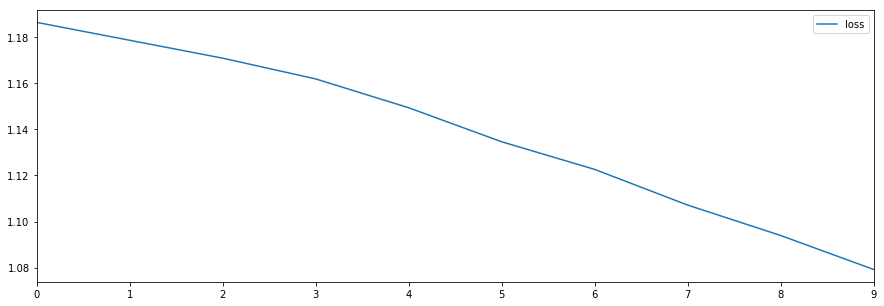

In [0]:
# Graphing Results

pd.DataFrame(model.history.history)[['loss']].plot(figsize=(15, 5))

In [0]:
predictions = model.predict([comments_test])
prediction_ = np.argmax(predictions, axis = 1)

In [0]:
confusion_matrix(category_test, prediction_)

array([[    0,     0,     0,     2,     0,     0],
       [    0,     0,   333,  1600,    34,     0],
       [    0,     0,  3486, 10197,   128,     0],
       [    0,     0,  3174, 12382,   188,     0],
       [    0,     0,   610,  2786,    65,     0],
       [    0,     0,    99,   561,    18,     0]])

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

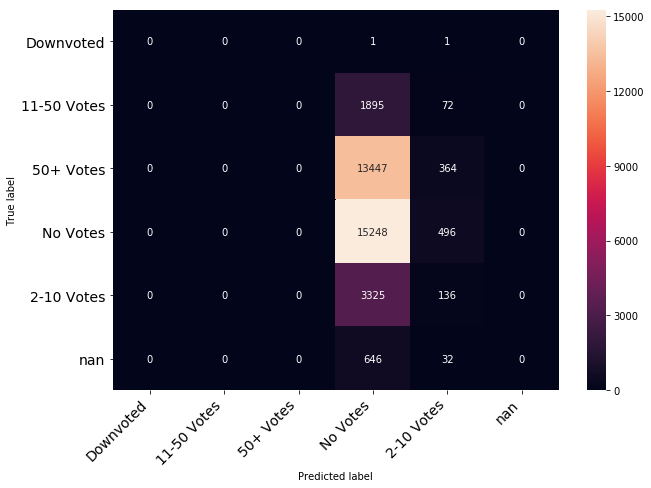

In [0]:
print_confusion_matrix(confusion_matrix(category_test, prediction_), new_df.score_category.values.unique().tolist());


In [0]:
results = pd.concat([category_test, new_df.body], axis=1, join='inner').reset_index(drop=True)
results = pd.concat([results, pd.Series(prediction_)], axis=1)
results.columns = ['Actual', 'Comment', 'Prediction']

In [0]:
results.head()

,Actual,Comment,Prediction
0,2,Lucheses,2
1,1,"Oh and cost-wise, it will ALWAYS be cheaper to...",2
2,2,I've seen enough Top Gear to know you're not f...,2
3,1,Direct links to images are not allowed on /r/C...,2
4,1,Decent all-around tint costs around $200 at an...,2


In [0]:
results[(results.Actual == 4) & (results.Prediction == 0) ].Comment.values

array([], dtype=object)